# Ensemble Models

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')


In [32]:
kz_data = pd.read_csv('/Users/kassi/Data Mining/Final/Code/data/model_ready/kz_modeling_ready.csv')
foreign_data = pd.read_csv('/Users/kassi/Data Mining/Final/Code/data/model_ready/foreign_modeling_ready.csv')

# Prepare data

In [33]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
def prepare_train_test_kz(df, test_size=0.2, random_state=42):
    """Split, encode categorical features, handle NaN, and scale (Kazakhstan)"""
    
    df = df.copy()
    
    # Target
    y = df['gpa']
    X = df.drop(columns=['gpa'])
    
    # Encode categorical + fill NaN
    for col in X.columns:
        if X[col].dtype == 'object' or str(X[col].dtype) == 'category':
            X[col] = X[col].astype(str).fillna('missing')
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col])
        else:
            X[col] = X[col].fillna(X[col].mean())
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

def prepare_train_test_foreign(df, test_size=0.2, random_state=42):
    """Split, encode categorical features, handle NaN, and scale (Foreign)"""
    
    df = df.copy()
    
    y = df['final_grade']
    X = df.drop(columns=['final_grade'])
    
    for col in X.columns:
        if X[col].dtype == 'object' or str(X[col].dtype) == 'category':
            X[col] = X[col].astype(str).fillna('missing')
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col])
        else:
            X[col] = X[col].fillna(X[col].mean())
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

kz_X_train, kz_X_test, kz_y_train, kz_y_test, kz_scaler = \
    prepare_train_test_kz(kz_data)

foreign_X_train, foreign_X_test, foreign_y_train, foreign_y_test, foreign_scaler = \
    prepare_train_test_foreign(foreign_data)

print("\nTrain/Test Split Complete!")
print(f"Kazakhstan - Train: {kz_X_train.shape}, Test: {kz_X_test.shape}")
print(f"Foreign - Train: {foreign_X_train.shape}, Test: {foreign_X_test.shape}")



Train/Test Split Complete!
Kazakhstan - Train: (96, 15), Test: (25, 15)
Foreign - Train: (519, 15), Test: (130, 15)


# Evaluation function

In [34]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, dataset_name):
    """Evaluate model"""
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, 
                                 scoring='r2', n_jobs=-1)
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    print(f"\n{'='*60}")
    print(f"{dataset_name} - {model_name}")
    print(f"{'='*60}")
    print(f"Train R²: {train_r2:.4f} | Test R²: {test_r2:.4f}")
    print(f"Train RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f}")
    print(f"Train MAE: {train_mae:.4f} | Test MAE: {test_mae:.4f}")
    print(f"CV R² (5-fold): {cv_mean:.4f} (+/- {cv_std:.4f})")
    
    results = {
        'Model': model_name,
        'Dataset': dataset_name,
        'Train_R2': train_r2,
        'Test_R2': test_r2,
        'Train_RMSE': train_rmse,
        'Test_RMSE': test_rmse,
        'Train_MAE': train_mae,
        'Test_MAE': test_mae,
        'CV_R2_Mean': cv_mean,
        'CV_R2_Std': cv_std
    }
    
    return results, model, y_test_pred

# Random Forest Regressor

In [35]:
print("\n" + "="*60)
print("RANDOM FOREST REGRESSOR")
print("="*60)

# Kazakhstan
kz_rf_results, kz_rf_model, kz_rf_pred = evaluate_model(
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    kz_X_train, kz_X_test, kz_y_train, kz_y_test,
    "Random Forest", "Kazakhstan"
)

# Foreign
foreign_rf_results, foreign_rf_model, foreign_rf_pred = evaluate_model(
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    foreign_X_train, foreign_X_test, foreign_y_train, foreign_y_test,
    "Random Forest", "Foreign"
)


RANDOM FOREST REGRESSOR

Kazakhstan - Random Forest
Train R²: 0.8463 | Test R²: -0.0367
Train RMSE: 0.2667 | Test RMSE: 0.8525
Train MAE: 0.1890 | Test MAE: 0.5851
CV R² (5-fold): -0.4777 (+/- 0.3938)

Foreign - Random Forest
Train R²: 0.9832 | Test R²: 0.9112
Train RMSE: 0.1484 | Test RMSE: 0.3500
Train MAE: 0.0997 | Test MAE: 0.2556
CV R² (5-fold): 0.8777 (+/- 0.0379)


# Gradient Boosting Regressor

In [36]:
print("\n" + "="*60)
print("GRADIENT BOOSTING REGRESSOR")
print("="*60)

# Kazakhstan
kz_gb_results, kz_gb_model, kz_gb_pred = evaluate_model(
    GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, 
                              max_depth=3, random_state=42),
    kz_X_train, kz_X_test, kz_y_train, kz_y_test,
    "Gradient Boosting", "Kazakhstan"
)

# Foreign
foreign_gb_results, foreign_gb_model, foreign_gb_pred = evaluate_model(
    GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, 
                              max_depth=3, random_state=42),
    foreign_X_train, foreign_X_test, foreign_y_train, foreign_y_test,
    "Gradient Boosting", "Foreign"
)


GRADIENT BOOSTING REGRESSOR

Kazakhstan - Gradient Boosting
Train R²: 0.9317 | Test R²: 0.1048
Train RMSE: 0.1778 | Test RMSE: 0.7922
Train MAE: 0.1418 | Test MAE: 0.5810
CV R² (5-fold): -0.7703 (+/- 0.4230)

Foreign - Gradient Boosting
Train R²: 0.9516 | Test R²: 0.9058
Train RMSE: 0.2521 | Test RMSE: 0.3604
Train MAE: 0.1896 | Test MAE: 0.2781
CV R² (5-fold): 0.8887 (+/- 0.0366)


# AdaBoost Regressor

In [37]:
print("\n" + "="*60)
print("ADABOOST REGRESSOR")
print("="*60)

# Kazakhstan
kz_ada_results, kz_ada_model, kz_ada_pred = evaluate_model(
    AdaBoostRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    kz_X_train, kz_X_test, kz_y_train, kz_y_test,
    "AdaBoost", "Kazakhstan"
)

# Foreign
foreign_ada_results, foreign_ada_model, foreign_ada_pred = evaluate_model(
    AdaBoostRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    foreign_X_train, foreign_X_test, foreign_y_train, foreign_y_test,
    "AdaBoost", "Foreign"
)


ADABOOST REGRESSOR

Kazakhstan - AdaBoost
Train R²: 0.7411 | Test R²: 0.0907
Train RMSE: 0.3461 | Test RMSE: 0.7984
Train MAE: 0.2870 | Test MAE: 0.5158
CV R² (5-fold): -0.0434 (+/- 0.1969)

Foreign - AdaBoost
Train R²: 0.8995 | Test R²: 0.8937
Train RMSE: 0.3634 | Test RMSE: 0.3829
Train MAE: 0.2961 | Test MAE: 0.3227
CV R² (5-fold): 0.8704 (+/- 0.0392)


# Compare All Ensemble Models

In [38]:
# Combine results
ensemble_results = [
    kz_rf_results, kz_gb_results, kz_ada_results,
    foreign_rf_results, foreign_gb_results, foreign_ada_results
]

ensemble_df = pd.DataFrame(ensemble_results)

print("\n" + "="*60)
print("ENSEMBLE MODELS COMPARISON")
print("="*60)
print(ensemble_df[['Model', 'Dataset', 'Test_R2', 'Test_RMSE', 'Test_MAE']])


ENSEMBLE MODELS COMPARISON
               Model     Dataset   Test_R2  Test_RMSE  Test_MAE
0      Random Forest  Kazakhstan -0.036692   0.852479  0.585072
1  Gradient Boosting  Kazakhstan  0.104765   0.792186  0.580991
2           AdaBoost  Kazakhstan  0.090656   0.798405  0.515771
3      Random Forest     Foreign  0.911194   0.349974  0.255560
4  Gradient Boosting     Foreign  0.905807   0.360431  0.278147
5           AdaBoost     Foreign  0.893719   0.382862  0.322706


# Compare with Regression Models

In [39]:
# Load regression results from notebook 06
regression_df = pd.read_csv('/Users/kassi/Data Mining/Final/Code/report/regression/regression_models_comparison.csv')

# Combine all models
all_models_df = pd.concat([regression_df, ensemble_df], ignore_index=True)

print("\n" + "="*60)
print("ALL MODELS COMPARISON")
print("="*60)
print(all_models_df[['Model', 'Dataset', 'Test_R2', 'Test_RMSE']].sort_values(
    ['Dataset', 'Test_R2'], ascending=[True, False]
))


ALL MODELS COMPARISON
                Model     Dataset   Test_R2  Test_RMSE
11      Random Forest     Foreign  0.911194   0.349974
12  Gradient Boosting     Foreign  0.905807   0.360431
13           AdaBoost     Foreign  0.893719   0.382862
5    Ridge Regression     Foreign  0.867949   0.426761
4   Linear Regression     Foreign  0.867946   0.426765
6    Lasso Regression     Foreign  0.850557   0.453996
7         Elastic Net     Foreign  0.850071   0.454733
3         Elastic Net  Kazakhstan  0.119526   0.785628
9   Gradient Boosting  Kazakhstan  0.104765   0.792186
10           AdaBoost  Kazakhstan  0.090656   0.798405
1    Ridge Regression  Kazakhstan  0.081228   0.802533
0   Linear Regression  Kazakhstan  0.060983   0.811326
2    Lasso Regression  Kazakhstan  0.049765   0.816158
8       Random Forest  Kazakhstan -0.036692   0.852479


# Visualize Model Performance

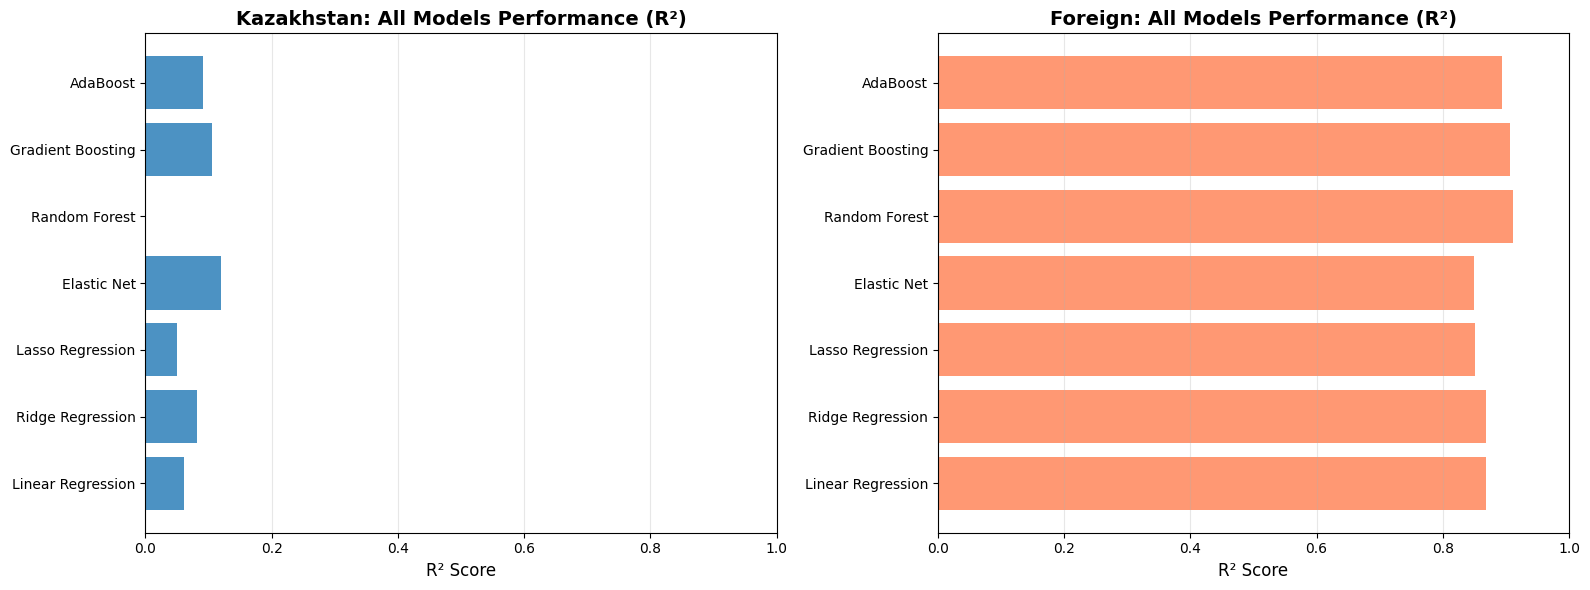

In [40]:
# Plot R² comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Kazakhstan
kz_models = all_models_df[all_models_df['Dataset'] == 'Kazakhstan']
axes[0].barh(kz_models['Model'], kz_models['Test_R2'], alpha=0.8)
axes[0].set_xlabel('R² Score', fontsize=12)
axes[0].set_title('Kazakhstan: All Models Performance (R²)', 
                  fontsize=14, fontweight='bold')
axes[0].set_xlim([0, 1])
axes[0].grid(axis='x', alpha=0.3)

# Foreign
foreign_models = all_models_df[all_models_df['Dataset'] == 'Foreign']
axes[1].barh(foreign_models['Model'], foreign_models['Test_R2'], 
             alpha=0.8, color='coral')
axes[1].set_xlabel('R² Score', fontsize=12)
axes[1].set_title('Foreign: All Models Performance (R²)', 
                  fontsize=14, fontweight='bold')
axes[1].set_xlim([0, 1])
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('/Users/kassi/Data Mining/Final/Code/figure/ensemble/all_models_r2_comparison.png', 
            dpi=300, bbox_inches='tight')
plt.show()

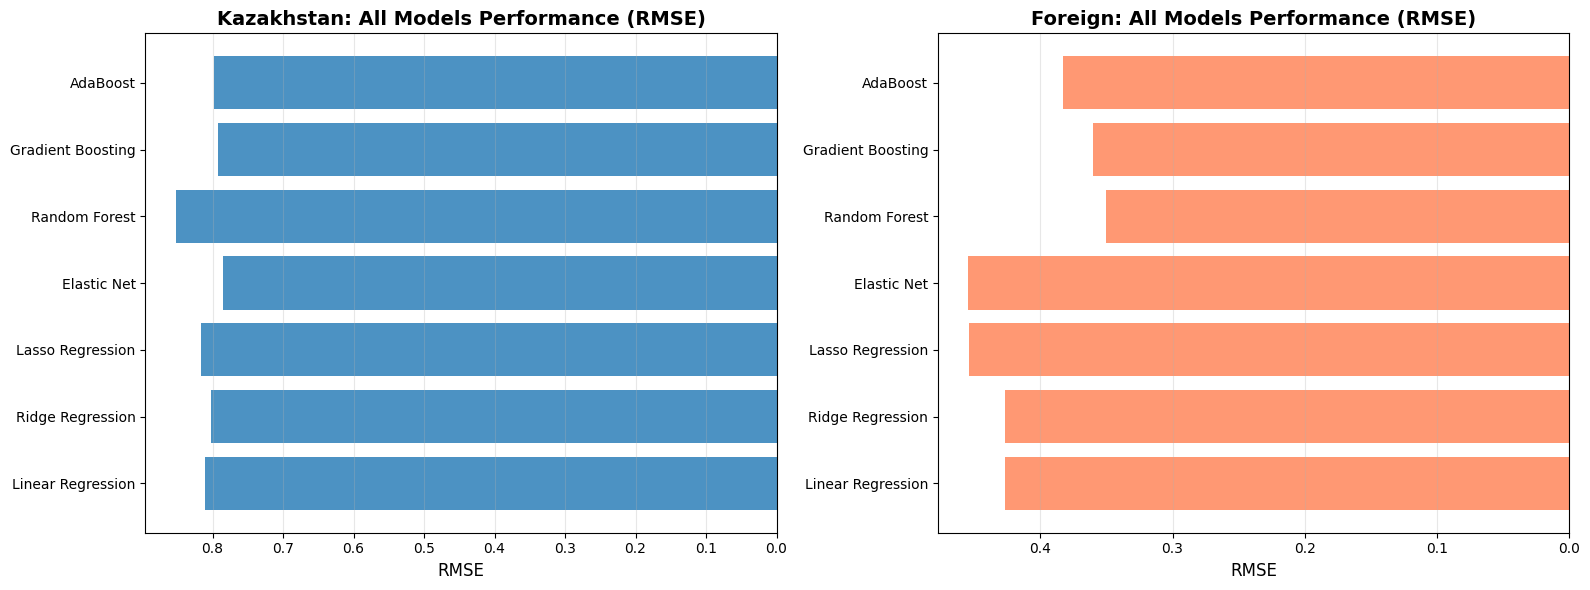

In [41]:
# Plot RMSE comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Kazakhstan
axes[0].barh(kz_models['Model'], kz_models['Test_RMSE'], alpha=0.8)
axes[0].set_xlabel('RMSE', fontsize=12)
axes[0].set_title('Kazakhstan: All Models Performance (RMSE)', 
                  fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)
axes[0].invert_xaxis()  # Lower RMSE is better

# Foreign
axes[1].barh(foreign_models['Model'], foreign_models['Test_RMSE'], 
             alpha=0.8, color='coral')
axes[1].set_xlabel('RMSE', fontsize=12)
axes[1].set_title('Foreign: All Models Performance (RMSE)', 
                  fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
axes[1].invert_xaxis()

plt.tight_layout()
plt.savefig('/Users/kassi/Data Mining/Final/Code/figure/ensemble/all_models_rmse_comparison.png', 
            dpi=300, bbox_inches='tight')
plt.show()


# Feature Importance Analysis

In [42]:
def plot_feature_importance(model, feature_names, model_name, dataset_name, top_n=15):
    """Plot feature importance"""
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        
        # Create dataframe
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values('Importance', ascending=False).head(top_n)
        
        # Plot
        plt.figure(figsize=(10, 8))
        plt.barh(importance_df['Feature'], importance_df['Importance'], alpha=0.8)
        plt.xlabel('Importance', fontsize=12)
        plt.title(f'{dataset_name}: {model_name}\nTop {top_n} Features', 
                  fontsize=14, fontweight='bold')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        
        return importance_df

In [44]:
kz_features = kz_data.drop('gpa', axis=1).columns
foreign_features = foreign_data.drop('final_grade', axis=1).columns

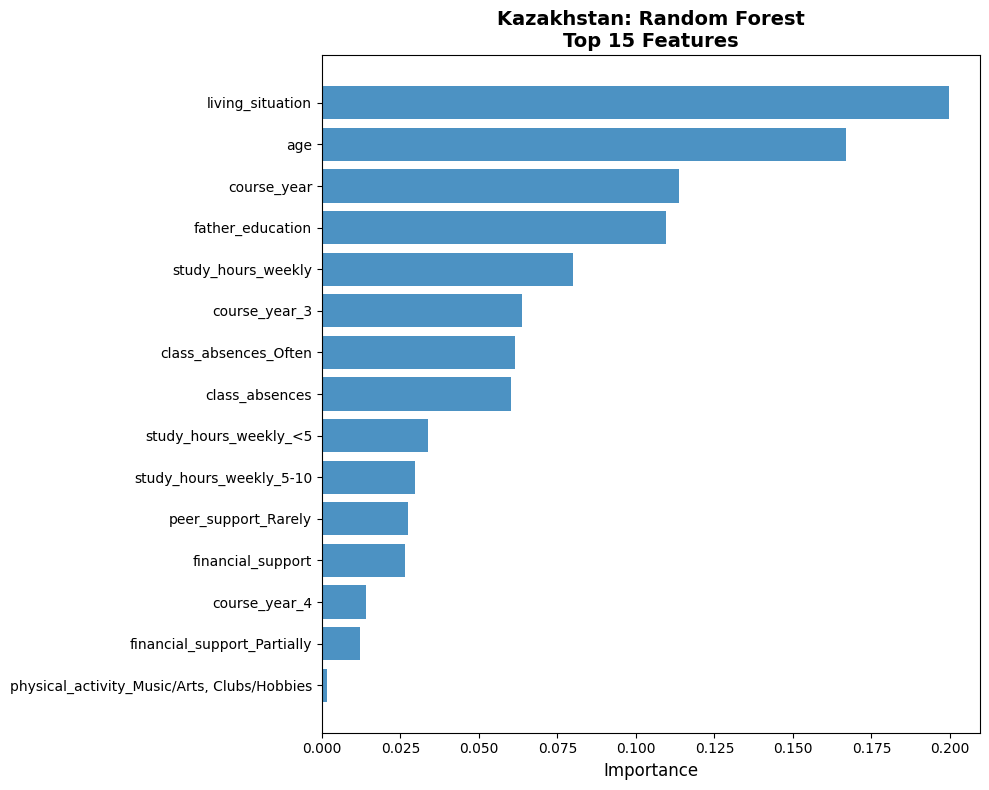

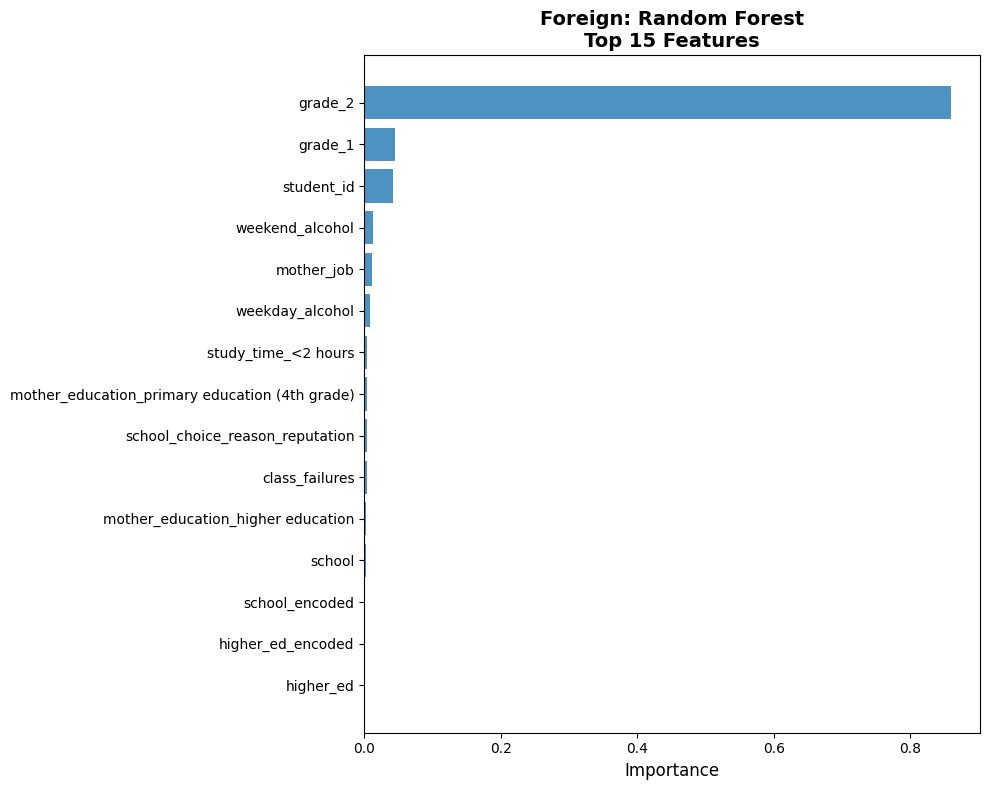

In [45]:
# Kazakhstan - Random Forest
kz_rf_importance = plot_feature_importance(
    kz_rf_model, kz_features, "Random Forest", "Kazakhstan"
)
plt.savefig('/Users/kassi/Data Mining/Final/Code/figure/ensemble/kz_rf_feature_importance.png', 
            dpi=300, bbox_inches='tight')
plt.show()

# Foreign - Random Forest
foreign_rf_importance = plot_feature_importance(
    foreign_rf_model, foreign_features, "Random Forest", "Foreign"
)
plt.savefig('/Users/kassi/Data Mining/Final/Code/figure/ensemble/foreign_rf_feature_importance.png', 
            dpi=300, bbox_inches='tight')
plt.show()

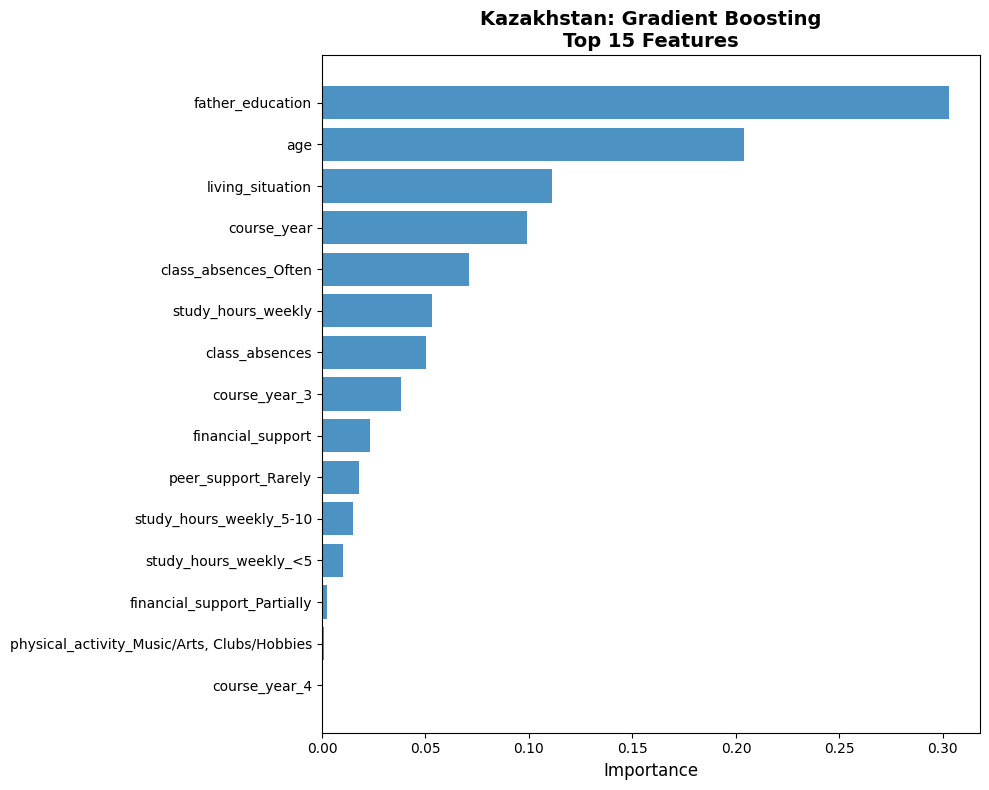

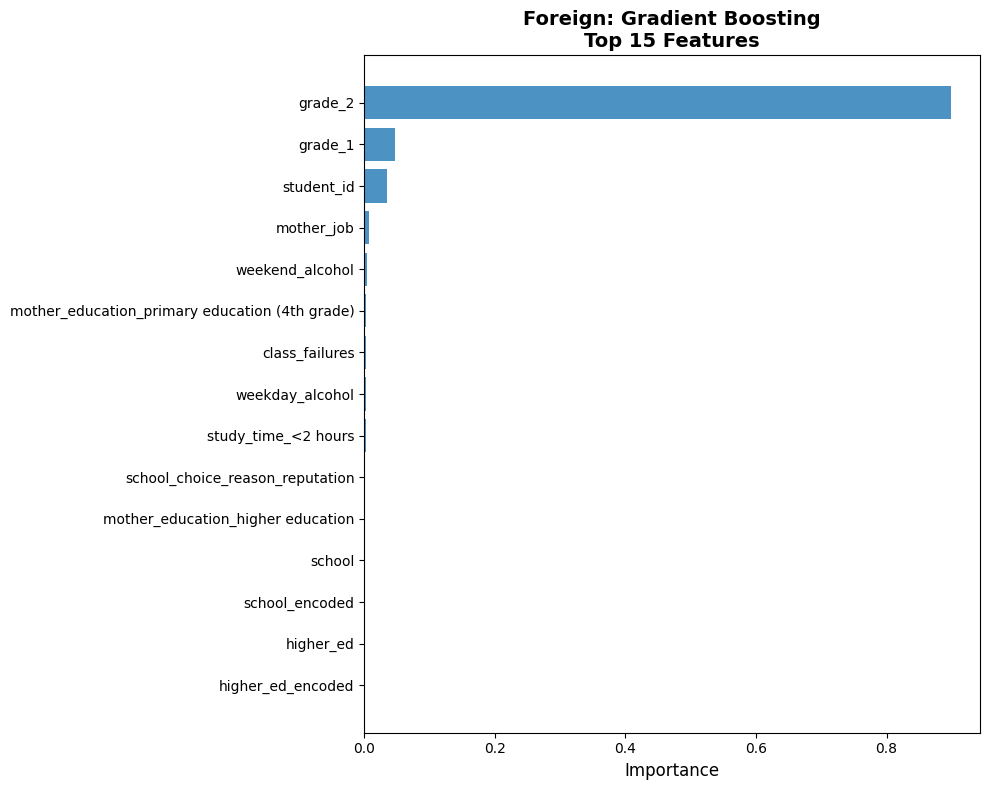

In [46]:
# Gradient Boosting importance
kz_gb_importance = plot_feature_importance(
    kz_gb_model, kz_features, "Gradient Boosting", "Kazakhstan"
)
plt.savefig('/Users/kassi/Data Mining/Final/Code/figure/ensemble/kz_gb_feature_importance.png', 
            dpi=300, bbox_inches='tight')
plt.show()

foreign_gb_importance = plot_feature_importance(
    foreign_gb_model, foreign_features, "Gradient Boosting", "Foreign"
)
plt.savefig('/Users/kassi/Data Mining/Final/Code/figure/ensemble/foreign_gb_feature_importance.png', 
            dpi=300, bbox_inches='tight')
plt.show()


# Compare Feature Importance Across Models

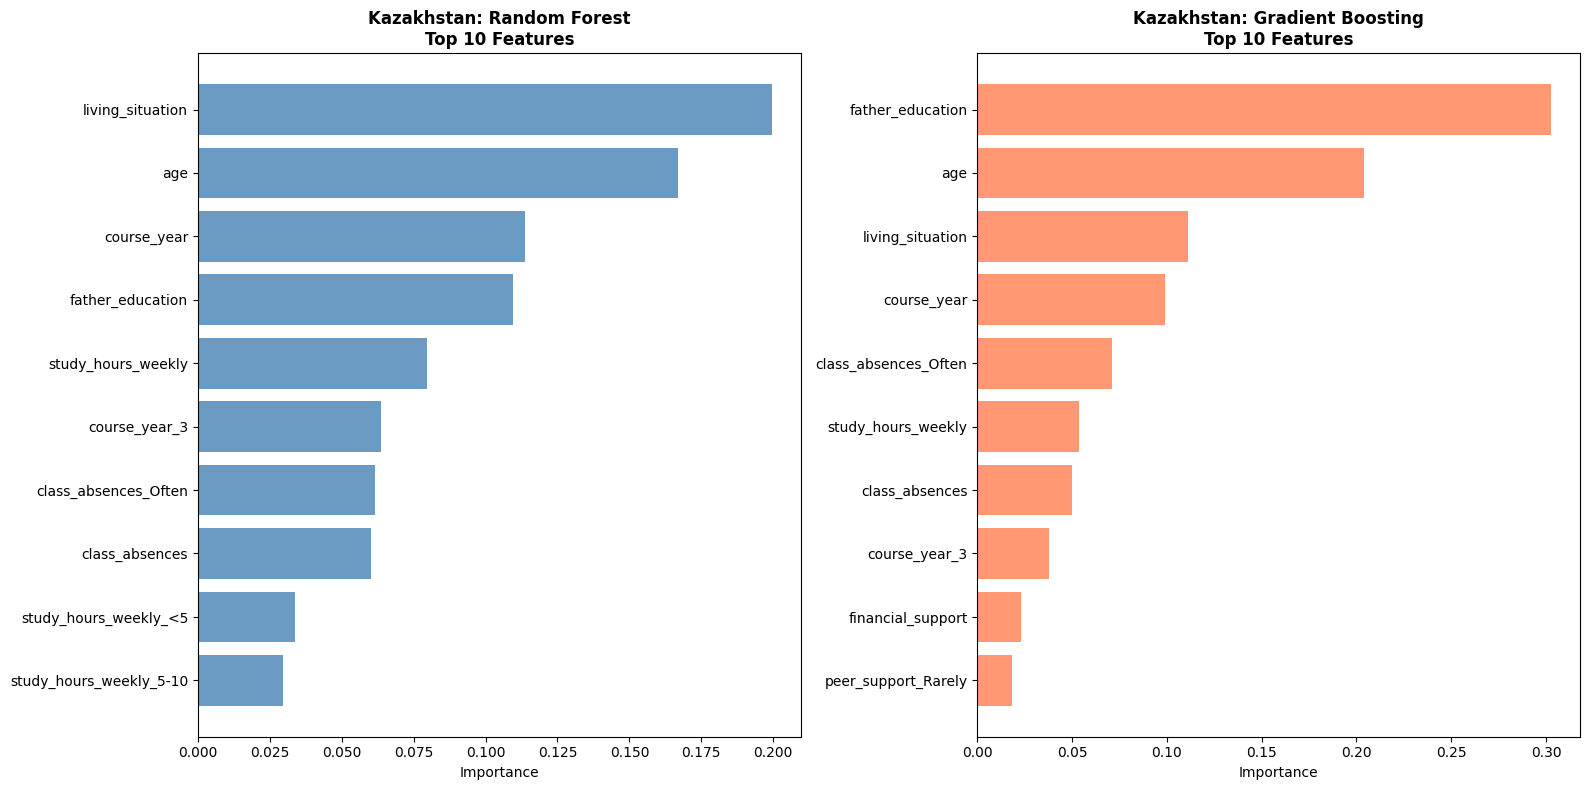

In [47]:
# Combine RF and GB importances for Kazakhstan
if kz_rf_importance is not None and kz_gb_importance is not None:
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # RF
    axes[0].barh(kz_rf_importance['Feature'].head(10), 
                 kz_rf_importance['Importance'].head(10), 
                 alpha=0.8, color='steelblue')
    axes[0].set_xlabel('Importance')
    axes[0].set_title('Kazakhstan: Random Forest\nTop 10 Features', 
                      fontsize=12, fontweight='bold')
    axes[0].invert_yaxis()
    
    # GB
    axes[1].barh(kz_gb_importance['Feature'].head(10), 
                 kz_gb_importance['Importance'].head(10), 
                 alpha=0.8, color='coral')
    axes[1].set_xlabel('Importance')
    axes[1].set_title('Kazakhstan: Gradient Boosting\nTop 10 Features', 
                      fontsize=12, fontweight='bold')
    axes[1].invert_yaxis()
    
    plt.tight_layout()
    plt.savefig('../results/figures/kz_feature_importance_comparison.png', 
                dpi=300, bbox_inches='tight')
    plt.show()

# Save Results

In [48]:
# Save all model results
all_models_df.to_csv('/Users/kassi/Data Mining/Final/Code/report/ensemble/all_models_comparison.csv', index=False)

# Save feature importances
if kz_rf_importance is not None:
    kz_rf_importance.to_csv('/Users/kassi/Data Mining/Final/Code/report/ensemble/kz_rf_feature_importance.csv', index=False)
if foreign_rf_importance is not None:
    foreign_rf_importance.to_csv('/Users/kassi/Data Mining/Final/Code/report/ensemble/foreign_rf_feature_importance.csv', index=False)

print("\nAll results saved!")



All results saved!


# Identify Best Models

In [49]:
# Best model for each dataset
kz_best = kz_models.loc[kz_models['Test_R2'].idxmax()]
foreign_best = foreign_models.loc[foreign_models['Test_R2'].idxmax()]

print("\n" + "="*60)
print("BEST MODELS")
print("="*60)
print(f"\nKazakhstan:")
print(f"  Model: {kz_best['Model']}")
print(f"  R²: {kz_best['Test_R2']:.4f}")
print(f"  RMSE: {kz_best['Test_RMSE']:.4f}")
print(f"  MAE: {kz_best['Test_MAE']:.4f}")

print(f"\nForeign:")
print(f"  Model: {foreign_best['Model']}")
print(f"  R²: {foreign_best['Test_R2']:.4f}")
print(f"  RMSE: {foreign_best['Test_RMSE']:.4f}")
print(f"  MAE: {foreign_best['Test_MAE']:.4f}")

# Save best models summary
best_models_summary = pd.DataFrame([
    {
        'Dataset': 'Kazakhstan',
        'Best_Model': kz_best['Model'],
        'Test_R2': kz_best['Test_R2'],
        'Test_RMSE': kz_best['Test_RMSE'],
        'Test_MAE': kz_best['Test_MAE']
    },
    {
        'Dataset': 'Foreign',
        'Best_Model': foreign_best['Model'],
        'Test_R2': foreign_best['Test_R2'],
        'Test_RMSE': foreign_best['Test_RMSE'],
        'Test_MAE': foreign_best['Test_MAE']
    }
])

best_models_summary.to_csv('/Users/kassi/Data Mining/Final/Code/report/ensemble/best_models_summary.csv', index=False)
print("\nBest models summary saved!")


BEST MODELS

Kazakhstan:
  Model: Elastic Net
  R²: 0.1195
  RMSE: 0.7856
  MAE: 0.5131

Foreign:
  Model: Random Forest
  R²: 0.9112
  RMSE: 0.3500
  MAE: 0.2556

Best models summary saved!
